In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

## Introduction

- in large datasets, every pair of variables has a statistically discernible non-zero correlation
- we need tools to distinguish between mere association from evidence of causation

Reasons for multivariate models:
1. statistical control of confounds (e.g. waffle houses and divorce rates both have "southerness" in common)
2. Multiple causation - a phenomenon may arise because of different causes. Multivariate models can help in such cases
3. Interaction (between variables)

This chapter takes a look at 1. and 2.


### 5.1 Spurious association

In [2]:
d = pd.read_csv('./rethinking/data/WaffleDivorce.csv', sep=';')

# standardize the predictor
d['MedianAgeMarriage.S'] = (d['MedianAgeMarriage'] - d['MedianAgeMarriage'].mean()).div(d['MedianAgeMarriage'].std())

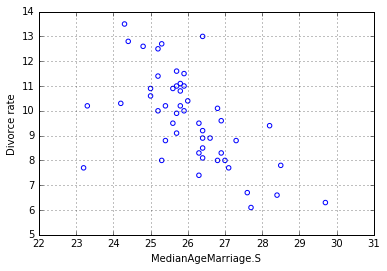

In [3]:
plt.scatter(d.MedianAgeMarriage, d.Divorce, facecolors='none', edgecolors='b')
plt.xlabel('MedianAgeMarriage.S'); plt.ylabel('Divorce rate');
plt.grid();

In [4]:
with pm.Model() as divorce_model:
    
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    mu = a + bA * d['MedianAgeMarriage.S']
    divorce = pm.Normal('divorce', mu = mu, sd = sigma, observed=d['Divorce'])
        
    map_estimate = pm.find_MAP(model=divorce_model)
    trace = pm.sample(10000, start=map_estimate)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Assigned NUTS to a
Assigned NUTS to bA
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 7.7 sec

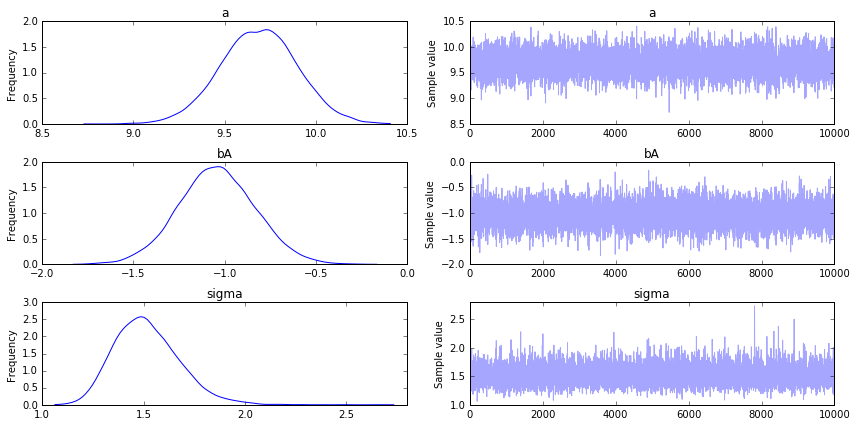

In [5]:
pm.traceplot(trace);

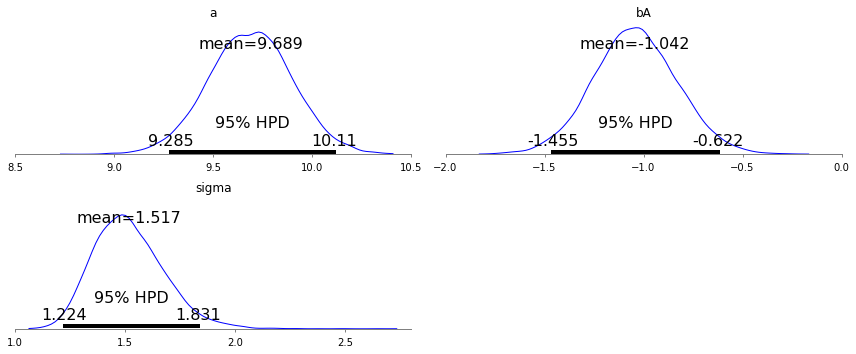

In [6]:
pm.plot_posterior(trace, kde_plot=True);

In [7]:
trace_df = pm.trace_to_dataframe(trace)

In [8]:
sampled_mus = trace_df.apply(lambda x: x['a'] + x['bA'] * d['MedianAgeMarriage.S'].sort_values(), axis=1)
sampled_mus.columns = d['MedianAgeMarriage.S'].sort_values().values

hpds = pd.DataFrame([pm.hpd(sampled_mus.iloc[:, i]) for i, col in enumerate(sampled_mus.columns)])
hpds.columns = ['HPD_lower', 'HPD_upper']
hpds.index = sampled_mus.columns

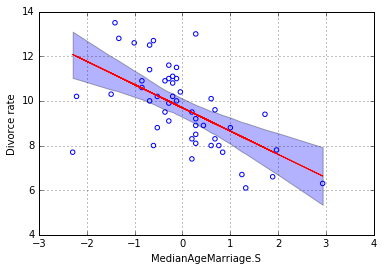

In [9]:
plt.scatter(d['MedianAgeMarriage.S'], d['Divorce'], facecolors='none', edgecolors='b')
plt.xlabel('MedianAgeMarriage.S'); plt.ylabel('Divorce rate');

line_points = trace_df['a'].mean() + trace_df['bA'].mean() * d['MedianAgeMarriage.S']
plt.plot(d['MedianAgeMarriage.S'], line_points, c='r')

plt.fill_between(hpds.index, y1=hpds.HPD_lower, 
                      y2=hpds.HPD_upper, alpha=0.3)

plt.grid();

#### 5.1.1 Multivariate notation

In [10]:
d['Marriage.S'] = (d['Marriage'] - d['Marriage'].mean()) / d['Marriage'].std()

In [11]:
with pm.Model() as divorce_model:
    
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    mu = a + bA * d['MedianAgeMarriage.S'] + bR * d['Marriage.S']
    divorce = pm.Normal('divorce', mu = mu, sd = sigma, observed=d['Divorce'])
        
    map_estimate = pm.find_MAP(model=divorce_model)
    trace = pm.sample(10000, start=map_estimate)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Assigned NUTS to a
Assigned NUTS to bA
Assigned NUTS to bR
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 8.3 sec

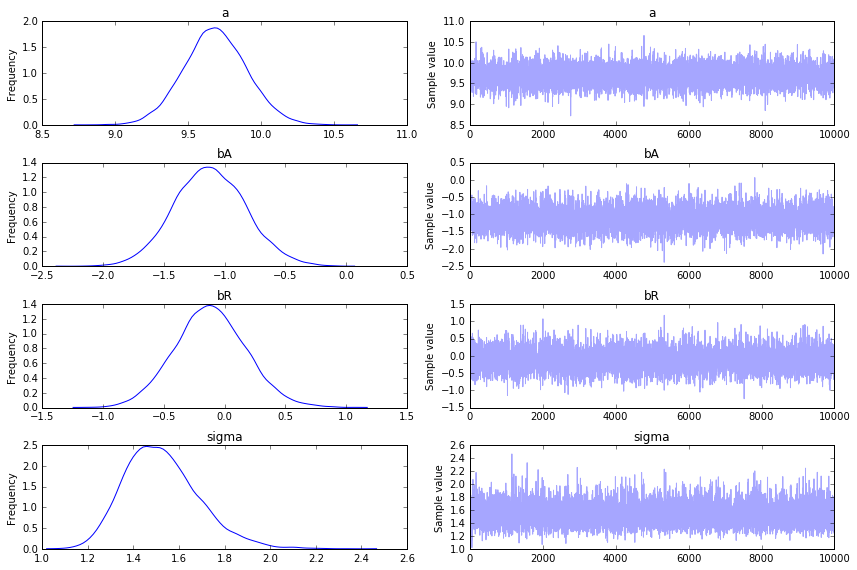

In [12]:
pm.traceplot(trace);

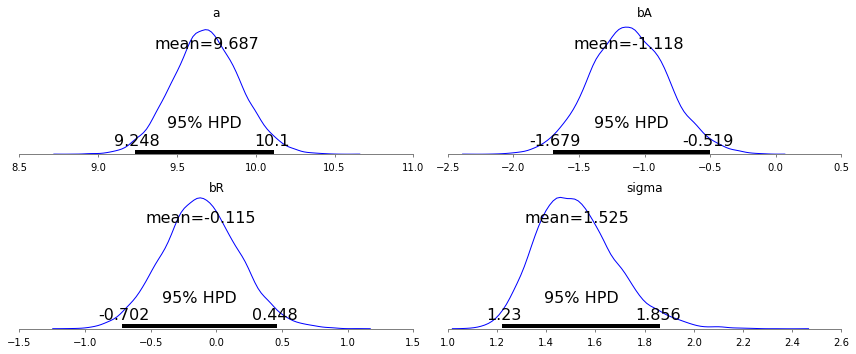

In [13]:
pm.plot_posterior(trace, kde_plot=True);

#### 5.1.3 Plotting multivariate posteriors

1. **Predictor residual plots**: These plots show the outcome against _residual_ predictor values
2. **Counterfactual plots**: These show the implied predictions for imaginary experiments in which the different predictor variables can be changed independently of one another
3. **Posterior prediction plots**:  These show model-based predictions against raw data, or otherwise display the error in prediction.

##### 5.1.3.1 Predictor residual plots

A predictor variable residual is the average prediction error when we use all of the other predictor variables to model a predictor of interest.

In our multivariate model of divorce rate, we have two predictors: (1) marriage rate and (2) median age at marriage. To compute predictor residuals for either, we just use the other predictor to model it. So for marriage rate, this is the model we need:

$$ R_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta * A_i $$
$$ \alpha \sim Normal(0, 10) $$
$$ \beta \sim Normal(0, 1) $$
$$ \sigma \sim Uniform(0, 10) $$

In [14]:
with pm.Model() as residual_divorce_model:
    
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    mu = a + b * d['MedianAgeMarriage.S']
    divorce = pm.Normal('Marriage', mu = mu, sd = sigma, observed=d['Marriage.S'])
        
    map_estimate = pm.find_MAP(model=residual_divorce_model)
    trace = pm.sample(1000, start=map_estimate)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Assigned NUTS to a
Assigned NUTS to b
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 1000 of 1000 complete in 0.8 sec

In [15]:
residual_trace_df = pm.trace_to_dataframe(trace)

In [16]:
# # Taken from:
# # https://github.com/pymc-devs/pymc3/blob/967f41f853946ae569178faf4b3e8c814382f70e/pymc3/distributions/transforms.py
# # - helper class to perform interval transform

# class Interval():
#     """Transform from real line interval [a,b] to whole real line."""

#     name = "interval"

#     def __init__(self, a,b):
#         self.a = a
#         self.b = b

#     def backward(self, x):
#         a, b = self.a, self.b
#         r = (b - a) * np.exp(x) / (1 + np.exp(x)) + a
#         return r

#     def forward(self, x):
#         a, b = self.a, self.b
#         r = np.log((x - a) / (b - x))
#         return r

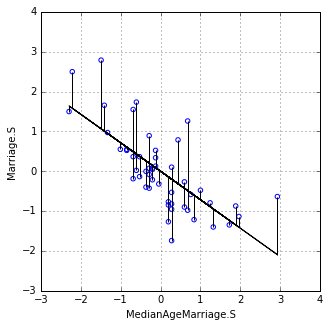

In [17]:
#
# Remember difference between axvline and vline
#


fig, ax = plt.subplots(figsize=(5, 5))

x_values = d['MedianAgeMarriage.S']
y_values = d['Marriage.S']
map_mu = map_estimate['a'] + map_estimate['b'] * x_values

plt.scatter(x_values, y_values, facecolors='none', edgecolors='b')
plt.plot(x_values, map_mu, c='k')

# Draw residual lines
ax.vlines(x=x_values, ymin=map_mu, ymax=d['Marriage.S'])

plt.xlabel('MedianAgeMarriage.S'); plt.ylabel('Marriage.S');
plt.grid();


When a residual is positive, that means the observed rate of marriage was in excess of what we'd expect, given the median age of marriage in that state. Whne a residual is negative, that means the observed rate was below what we'd expect. In simpler terms, States with positive residuals marry fast for their age, while States with negative residual marry slow for their median age of marriage. 

Notice that the residuals are variation in marriage rate that is left over, after taking out the purely linear relationship between the two variables. 

Now to use these residuals, let's put them on a horizontal axis and plot them against the actual outcome of interest, divorce rate.

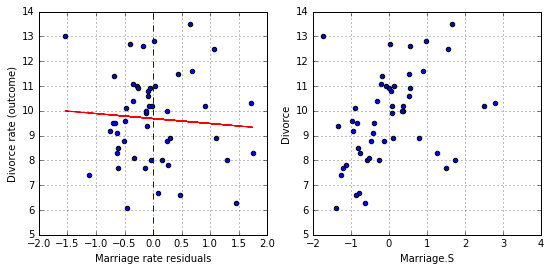

In [18]:
fig, (ax_left, ax_right) = plt.subplots(1,2,figsize=(9,4))

residuals = y_values - map_mu

ax_left.scatter(residuals, d['Divorce'])

slope, intercept = np.polyfit(residuals, d['Divorce'], 1)
ax_left.plot(residuals, intercept + slope * residuals, c='r')
ax_left.axvline(x=0, ls='--')
ax_left.set_xlabel('Marriage rate residuals'); ax_left.set_ylabel('Divorce rate (outcome)');
ax_left.grid();

ax_right.scatter(d['Marriage.S'], d['Divorce']);
ax_right.set_xlabel('Marriage.S'); ax_right.set_ylabel('Divorce');
ax_right.grid();


You can think of this plot as displaying the linear relationship between divorce and marriage rates, having
statistically _controlled_ for median age of marriage (or all other predictors). The vertical dashed line indicates marriage rate that exactly matches the expectation of marriage rate from the regression on median age at marriage. States to the right of the dashed line marry faster than expected (based on all other predictors). States to the left of the line marry slower than expected.  

Average divorce rate on both sides of the line is about the same, and so the regression line demonstrates little relationship between divorce and marriage and marriage rates. The slope of the regression line is -0.13, exactly what we found in the multivariate model.

So what's the point of all of this? There's direct value in seeing the model-based predictions displayed against the outcome, after subtracting out the influence of other predictors. (...) But this procedure also brings home the message that regression models answer with the remaining association of each predictor with the outcome, after already knowing the other predictors -- which is why the slopes are the same as the parameter values. In computing the predictor residual plots, you have to perform the calculation yourself, whereas in the multivariate model, it all happens automatically. 

Linear regression models do all of this with a very specific **additive** model of how predictors relate to one another. But predictor variables can be related to one another in non-additive ways. The basic logic of statistical control does not change in those cases, but the details definitely do, and these residual plots do not in general work the same way.

##### 5.1.3.2 Counterfactual plots

# Practice

All problems below use the `foxes` data.

1. `group`: Number of the social group the individual fox belongs to
2. `avgfood`: The average amount of food available in the territory.
3. `groupsize`: The number of foxes in the social group.
4. `area`: Size of the territory
5. `weight`: Body weight of the individual fox

In [19]:
foxes = pd.read_csv('./rethinking/data/foxes.csv', sep=';')

# standardize
foxes['area_s'] = (foxes['area'] - foxes['area'].mean()).div(foxes['area'].std())
foxes['groupsize_s'] = (foxes['groupsize'] - foxes['groupsize'].mean()).div(foxes['groupsize'].std())

5H1. Fit two bivariate Gaussian regressions: 

1. `weight` as a function of `area`
2. `weight` as a linear function of `groupsize`

Plot results, display MAP line and 95% interval of the mean. Is either variable important for predicting fox body weight?


In [20]:
foxes.head()

,group,avgfood,groupsize,area,weight,area_s,groupsize_s
0,1,0.37,2,1.09,5.02,-2.239596,-1.524089
1,1,0.37,2,1.09,2.84,-2.239596,-1.524089
2,2,0.53,2,2.05,5.33,-1.205508,-1.524089
3,2,0.53,2,2.05,6.07,-1.205508,-1.524089
4,3,0.49,2,2.12,5.85,-1.130106,-1.524089


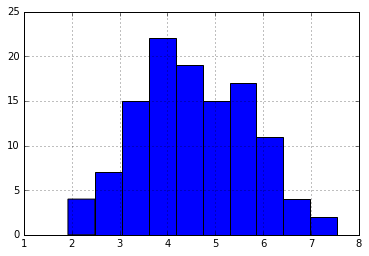

In [21]:
foxes.weight.hist()

In [22]:
with pm.Model() as m5H1_1:
    pm.glm.glm('weight ~ area_s', foxes)
    m5H1_1_map = pm.find_MAP(model=m5H1_1)
    trace_m5H1_1 = pm.sample(1000, model=m5H1_1)
    
with pm.Model() as m5H1_2:
    pm.glm.glm('weight ~ groupsize_s', foxes)
    m5H1_2_map = pm.find_MAP(model=m5H1_2)
    trace_m5H1_2 = pm.sample(1000, model=m5H1_2)

Applied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to area_s
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.3 secApplied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to groupsize_s
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.5 sec

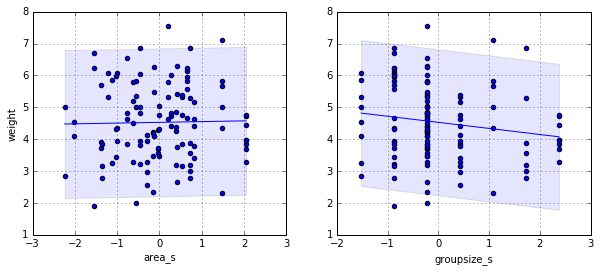

In [43]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 4))

ax_left.scatter(foxes['area_s'], foxes['weight'])
ax_left.set_xlabel('area_s'); ax_left.set_ylabel('weight');

ax_right.scatter(foxes['groupsize_s'], foxes['weight'])
ax_right.set_xlabel('groupsize_s'); ax_left.set_ylabel('weight');

# left line
map_line_left = m5H1_1_map['Intercept'] + foxes['area_s'].sort_values() * m5H1_1_map['area_s']
map_line_left_upper = map_line_left + 1.96 * np.exp(m5H1_1_map['sd_log_'])
map_line_left_lower = map_line_left - 1.96 * np.exp(m5H1_1_map['sd_log_'])

ax_left.plot(foxes['area_s'].sort_values(), map_line_left)
ax_left.fill_between(foxes['area_s'].sort_values(), y1=map_line_left_lower, y2=map_line_left_upper, alpha=0.1)

# right line
map_line_right = m5H1_2_map['Intercept'] + foxes['groupsize_s'].sort_values() * m5H1_2_map['groupsize_s']
map_line_right_upper = map_line_right + 1.96 * np.exp(m5H1_2_map['sd_log_'])
map_line_right_lower = map_line_right - 1.96 * np.exp(m5H1_2_map['sd_log_'])

ax_right.plot(foxes['groupsize_s'].sort_values(), map_line_right)
ax_right.fill_between(foxes['groupsize_s'].sort_values(), y1=map_line_right_lower, y2=map_line_right_upper, alpha=0.1)

ax_left.grid(); ax_right.grid();

In [44]:
with pm.Model() as m5H2:
    pm.glm.glm('weight ~ area_s + groupsize_s', foxes)
    map_m5H2 = pm.find_MAP(model=m5H2)
    trace_m5H2 = pm.sample(1000, model=m5H2)

Applied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to area_s
Assigned NUTS to groupsize_s
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.5 sec

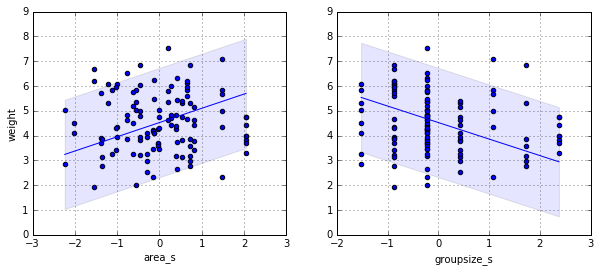

In [47]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 4))

ax_left.scatter(foxes['area_s'], foxes['weight'])
ax_left.set_xlabel('area_s'); ax_left.set_ylabel('weight');

ax_right.scatter(foxes['groupsize_s'], foxes['weight'])
ax_right.set_xlabel('groupsize_s'); ax_left.set_ylabel('weight');

# left line
map_line_left = (map_m5H2['Intercept'] 
                 + foxes['area_s'].sort_values() * map_m5H2['area_s'] 
                 + foxes['groupsize_s'].mean() * map_m5H2['groupsize_s'])

line_std = np.exp(map_m5H2['sd_log_'])

map_line_left_upper = map_line_left + 1.96 * line_std
map_line_left_lower = map_line_left - 1.96 * line_std

ax_left.plot(foxes['area_s'].sort_values(), map_line_left)
ax_left.fill_between(foxes['area_s'].sort_values(), y1=map_line_left_lower, y2=map_line_left_upper, alpha=0.1)

# # right line

map_line_right = (map_m5H2['Intercept'] 
                 + foxes['area_s'].mean() * map_m5H2['area_s'] 
                 + foxes['groupsize_s'].sort_values() * map_m5H2['groupsize_s'])

map_line_right_upper = map_line_right + 1.96 * line_std
map_line_right_lower = map_line_right - 1.96 * line_std

ax_right.plot(foxes['groupsize_s'].sort_values(), map_line_right)
ax_right.fill_between(foxes['groupsize_s'].sort_values(), y1=map_line_right_lower, y2=map_line_right_upper, alpha=0.1)

ax_left.grid(); ax_right.grid();

In [48]:
map_m5H2

{'Intercept': array(4.5296551755031755),
 'area_s': array(0.5738655521350643),
 'groupsize_s': array(-0.6655482053288079),
 'sd_log_': array(0.11616459138575488)}